# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [89]:
# import libraries
import pandas as pd
import datetime


from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType, DateType, StringType
from pyspark.sql.functions import date_format, hour, asc, desc, col, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql import Window
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, StandardScaler, VectorAssembler

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# create a Spark session
#configure = sparkConf().setAppName("Sparkify").setMaster("local")
#sc = SparkContext(conf=configure)

spark = SparkSession \
.builder \
.appName('Sparkify') \
.getOrCreate()

In [3]:
spark.sparkContext.getConf().getAll()

[('spark.app.id', 'local-1608745884188'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Sparkify'),
 ('spark.driver.host', '50ee032d3ba8'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.port', '34363')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
path='mini_sparkify_event_data.json'
data = spark.read.json(path)

In [5]:
data.printSchema()
#data.describe().show()
data.take(5)
#data.show(n=1)
data.count()
data.show(n=5)

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|     

In [6]:
data.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



In [7]:
###Number of unique userIds
data.select("userId").distinct().count()   ###This can include null userId

226

In [8]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [9]:
data=data.withColumn("hour", get_hour(data.ts))
data.head()
data.select("hour").dropDuplicates().show()

+----+
|hour|
+----+
|   7|
|  15|
|  11|
|   3|
|   8|
|  22|
|  16|
|   0|
|   5|
|  18|
|  17|
|   6|
|  19|
|  23|
|   9|
|   1|
|  20|
|  10|
|   4|
|  12|
+----+
only showing top 20 rows



In [10]:
songs_in_hour = data.filter(data.page == "NextSong").groupby(data.hour).count().orderBy(data.hour.cast("float"))

In [11]:
songs_in_hour.show()
songs_in_hour.printSchema()
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

+----+-----+
|hour|count|
+----+-----+
|   0| 9062|
|   1| 8388|
|   2| 8336|
|   3| 8355|
|   4| 8147|
|   5| 8178|
|   6| 8054|
|   7| 8091|
|   8| 8253|
|   9| 8498|
|  10| 8882|
|  11| 8830|
|  12| 9326|
|  13| 9644|
|  14|10494|
|  15|11354|
|  16|11636|
|  17|11460|
|  18|11124|
|  19|10930|
+----+-----+
only showing top 20 rows

root
 |-- hour: string (nullable = true)
 |-- count: long (nullable = false)



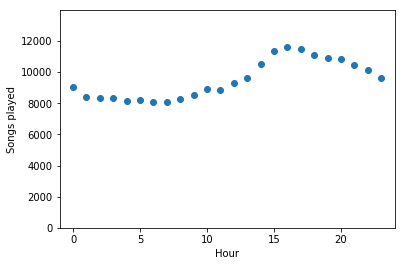

In [12]:
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

In [13]:
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x /1000.0).strftime("%m-%d-%Y %H:%M:%S"))
data=data.withColumn("tst", get_time(data.ts))
#data=data.withColumn("registrationt", get_time(data.registration))
#data.select(['ts', 'tst', 'registration', 'registrationt']).show()
#data.select(['ts', 'tst']).show()
data.select(['tst']).show()
#data.select(hour(data['tst']))hour.show()
#data.select(['ts', 'tst', 'hour']).show()

+-------------------+
|                tst|
+-------------------+
|10-01-2018 00:01:57|
|10-01-2018 00:03:00|
|10-01-2018 00:06:34|
|10-01-2018 00:06:56|
|10-01-2018 00:11:16|
|10-01-2018 00:11:18|
|10-01-2018 00:14:46|
|10-01-2018 00:14:59|
|10-01-2018 00:15:05|
|10-01-2018 00:18:04|
|10-01-2018 00:19:06|
|10-01-2018 00:19:10|
|10-01-2018 00:20:18|
|10-01-2018 00:22:55|
|10-01-2018 00:22:56|
|10-01-2018 00:24:01|
|10-01-2018 00:26:16|
|10-01-2018 00:27:48|
|10-01-2018 00:28:07|
|10-01-2018 00:29:04|
+-------------------+
only showing top 20 rows



In [14]:
#data.select(['tst']).printSchema()

In [15]:
data = data.withColumn('hour', hour(data.tst))
data.select(['hour']).show()

+----+
|hour|
+----+
|null|
|null|
|null|
|null|
|null|
|null|
|null|
|null|
|null|
|null|
|null|
|null|
|null|
|null|
|null|
|null|
|null|
|null|
|null|
|null|
+----+
only showing top 20 rows



In [16]:
data_tst=data.filter(data.page == "NextSong").groupby(data.hour).count().orderBy(data.hour.cast("float"))

In [17]:
data_valid = data.dropna(how = "any", subset = ["userId", "sessionId"])

In [18]:
data_valid.count()

286500

In [19]:
###Remove rows without userId
data_valid = data_valid.filter(data_valid["userId"] != "")
data_valid.count()

278154

In [20]:
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
data_valid = data_valid.withColumn("downgraded", flag_downgrade_event("page"))
#data_valid.filter(data.page == "Submit Downgrade").show(5)
#data_valid.filter((data_valid.userId == "131") & (data_valid.page == "Submit Downgrade")).show()
data_valid.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----+-------------------+----------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|hour|                tst|downgraded|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----+-------------------+----------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|null|10-01-2018 00:01:57|    

   downgraded_user gender  count
0             True      F     28
1            False      M    100
2             True      M     21
3            False      F     76


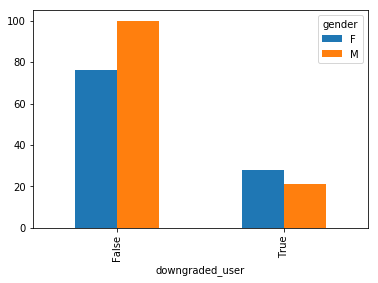

In [21]:
downgrade_list = data_valid.filter(data_valid.page=="Submit Downgrade" ).select("userId").distinct()
downgraded_users = [(row['userId']) for row in downgrade_list.collect()]
#print(downgraded_users)
data_valid = data_valid.withColumn('downgraded_user', data_valid.userId.isin(downgraded_users))
#print(data_valid.show())
down_count=data_valid.dropDuplicates(["userId", "gender"]).groupby(["downgraded_user", "gender"]).count().toPandas()
print(down_count)
down_count.pivot(index='downgraded_user', columns='gender', values='count').plot(kind='bar')

In [22]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding,0)

In [23]:
data_valid = data_valid.withColumn("phase", Fsum("downgraded").over(windowval))

  level gender   count
0  free      M   26049
3  free      F   29672
1  paid      M   97527
2  paid      F  124906


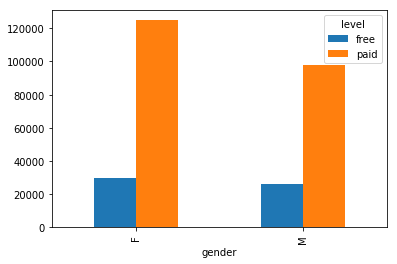

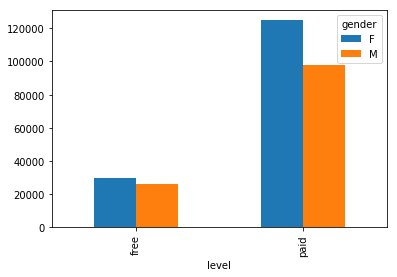

In [24]:
#Number of female users
#print(data_valid.filter(data_valid.gender== 'F').select('userId', 'gender').dropDuplicates().count())
#data_valid.filter(data_valid.gender== 'M').select('userId', 'gender').dropDuplicates().count()
##This is by log, not by userId

plot_count = data_valid.select('userId','level','gender').groupby('level','gender').count().toPandas().sort_values(by='count')
print(plot_count)
plot_count.pivot(index='gender', columns='level', values='count').plot(kind='bar')
plot_count.pivot(index='level', columns='gender', values='count').plot(kind='bar')
###Showed more females with paid account 

    level                                          userAgent  count
37   free  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2...      5
53   free  Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0)...     25
11   free  Mozilla/5.0 (Macintosh; Intel Mac OS X 10.8; r...     35
73   paid  Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0)...     37
100  free  Mozilla/5.0 (Windows NT 6.1; WOW64; rv:24.0) G...     62
47   free  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3...     70
23   free  Mozilla/5.0 (Windows NT 6.2; WOW64; rv:31.0) G...     76
44   free  "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/5...     97
20   free  "Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537....    105
67   free  Mozilla/5.0 (Windows NT 6.0; rv:31.0) Gecko/20...    141
25   free  Mozilla/5.0 (X11; Linux x86_64; rv:31.0) Gecko...    148
32   paid  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_5...    154
81   free  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2...    186
71   free  "Mozilla/5.0 (Macintosh; Intel Mac OS

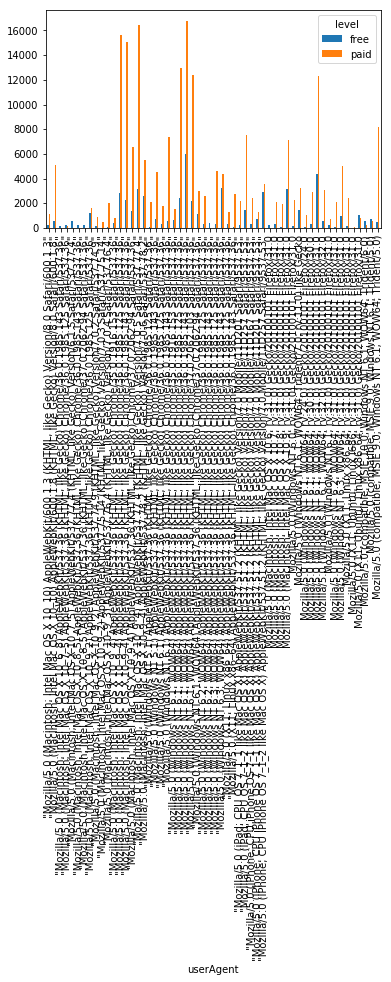

In [25]:
plot_count = data_valid.select('userId','level','userAgent').groupby('level','userAgent').count().toPandas().sort_values(by='count')
print(plot_count)
plot_count.pivot(index='userAgent', columns='level', values='count').plot(kind='bar')


In [26]:
#Most played artist and number of songs
songs_by_artist = data_valid.filter(data_valid.page == 'NextSong').select('Artist').groupBy('Artist')\
    .agg({'Artist':'count'}).withColumnRenamed('count(Artist)', 'Artistcount').sort(desc('Artistcount'))
songs_by_artist.show()
artist_count=songs_by_artist.toPandas().head(10)
print(artist_count)
#artist_count=songs_by_artist.toPandas().head(10)
#print(artist_count)
#plt.scatter(artist_count['Artist'], artist_count['Artistcount'])
#plt.xlim(-1, 24);
#plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
#plt.xlabel("Hour")
#plt.ylabel("Songs played");

+--------------------+-----------+
|              Artist|Artistcount|
+--------------------+-----------+
|       Kings Of Leon|       1841|
|            Coldplay|       1813|
|Florence + The Ma...|       1236|
|       Dwight Yoakam|       1135|
|            BjÃÂ¶rk|       1133|
|      The Black Keys|       1125|
|                Muse|       1090|
|       Justin Bieber|       1044|
|        Jack Johnson|       1007|
|              Eminem|        953|
|           Radiohead|        884|
|     Alliance Ethnik|        876|
|               Train|        854|
|        Taylor Swift|        840|
|         OneRepublic|        828|
|         The Killers|        822|
|         Linkin Park|        787|
|         Evanescence|        781|
|            Harmonia|        729|
|       Guns N' Roses|        713|
+--------------------+-----------+
only showing top 20 rows

                   Artist  Artistcount
0           Kings Of Leon         1841
1                Coldplay         1813
2  Florence + The

In [27]:
###Number of songs listened between visiting Home pages
function = udf(lambda ishome : int(ishome == 'Home'), IntegerType())

user_window = Window \
    .partitionBy('userID') \
    .orderBy(desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

cusum = data.filter((data.page == 'NextSong') | (data.page == 'Home')) \
    .select('userID', 'page', 'ts') \
    .withColumn('homevisit', function(col('page'))) \
    .withColumn('period', Fsum('homevisit').over(user_window))

cusum.show(80)

cusum.filter((cusum.page == 'NextSong')) \
    .groupBy('userID', 'period') \
    .agg({'period':'count'}) \
    .agg({'count(period)':'avg'}).show(80)

+------+--------+-------------+---------+------+
|userID|    page|           ts|homevisit|period|
+------+--------+-------------+---------+------+
|100010|NextSong|1542823951000|        0|     0|
|100010|NextSong|1542823682000|        0|     0|
|100010|NextSong|1542823567000|        0|     0|
|100010|NextSong|1542823248000|        0|     0|
|100010|NextSong|1542822946000|        0|     0|
|100010|NextSong|1542822641000|        0|     0|
|100010|NextSong|1542822434000|        0|     0|
|100010|NextSong|1542822170000|        0|     0|
|100010|NextSong|1542821943000|        0|     0|
|100010|NextSong|1542821662000|        0|     0|
|100010|NextSong|1542821317000|        0|     0|
|100010|NextSong|1542820950000|        0|     0|
|100010|NextSong|1542820651000|        0|     0|
|100010|NextSong|1542820437000|        0|     0|
|100010|NextSong|1542820179000|        0|     0|
|100010|NextSong|1542819919000|        0|     0|
|100010|NextSong|1542819682000|        0|     0|
|100010|NextSong|154

      userID  period  count
0     100010       0     24
6215  300014       0     32
9195      72       0     30
4546  200003       0      3
1115     112       0     21
6211  100019       0     11
4583  100015       0     99
8045  200004       0     37
2010      35       0     65
783   300017       0     30
4640  300023       0     18
1529     133       0     17
4543      90       0     21
9173      94       0      9
8110  300005       0     18
6145      58       0      2
4707  300024       0     72
6111      86       0     11
9084      91       0     17
4708     128       0     62
8126  100017       0      4
2584       5       0      3
6084  200017       0     40
1067      69       0     11
8130  300020       0     75
6207  100011       0      1
9040      66       0     57
9200      74       0     13
4539      68       0      5
9341      76       0     10
...      ...     ...    ...
8631      39     324      7
8632      39     325     13
8633      39     326      4
8634      39     327

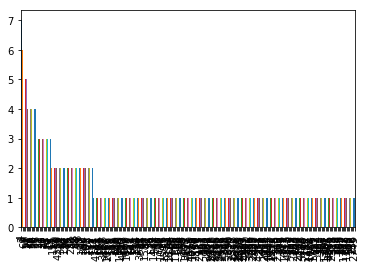

In [28]:
plot_count=cusum.filter((cusum.page == 'NextSong')).groupBy('userID', 'period').count().toPandas().sort_values(by='period')
print(plot_count)
play_count=plot_count.groupby("period").agg({"count": "sum"})
print(play_count)
play_count['count'].value_counts().plot(kind='bar')

In [29]:
#data_valid.filter(data_valid.page == 'free').select('Artist').groupBy('Artist')\
   # .agg({'Artist':'count'}).withColumnRenamed('count(Artist)', 'Artistcount').sort(desc('Artistcount')).show()

In [30]:
#data_valid.filter(data_valid.page == "NextSong").show()

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [31]:
churned_col = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df_churned = data_valid.withColumn("churned", churned_col('page'))
churned_rate = df_churned.groupby("userId").agg({"churned": "sum"}).select(avg("sum(churned)")).collect()[0]["avg(sum(churned))"]
print("churned: {:.2f}%".format(churned_rate * 100))
#plot_count = df_churned.select('userId','level','churned').groupby('level','churned').count().toPandas().sort_values(by='count')
#print(plot_count)
#plot_count.pivot(index='churned', columns='level', values='count').plot(kind='bar')

churned: 23.11%


   userId  sum(churned)
0  100010             0
1  200002             0
2     125             1
3      51             1
4     124             0
5       7             0
6      54             1
7      15             0
8     155             0
9     132             0


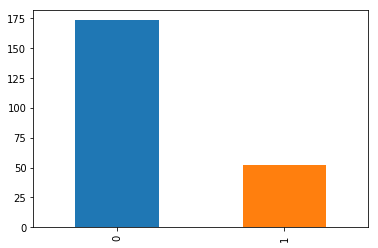

In [32]:
churn_count=df_churned.groupby("userId").agg({"churned": "sum"}).toPandas()
print(churn_count.head(10))
churn_count['sum(churned)'].value_counts().plot(kind='bar')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [52]:
length = df_churned.groupby('userId').agg({"length": "sum"}).withColumnRenamed("sum(length)", "length")
print(length.show(5))

+------+------------------+
|userId|            length|
+------+------------------+
|100010| 66940.89735000003|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927899999|
+------+------------------+
only showing top 5 rows

None


In [53]:
thumbs_up = df_churned.filter(df_churned["page"] == 'Thumbs Up').groupby('userId').count()
print(thumbs_up.show(5))
thumbs_down = df_churned.filter(df_churned["page"] == 'Thumbs Down').groupby('userId').count()
print(thumbs_down.show(5))

+------+-----+
|userId|count|
+------+-----+
|100010|   17|
|200002|   21|
|    51|  100|
|   124|  171|
|     7|    7|
+------+-----+
only showing top 5 rows

None
+------+-----+
|userId|count|
+------+-----+
|100010|    5|
|200002|    6|
|    51|   21|
|   124|   41|
|     7|    1|
+------+-----+
only showing top 5 rows

None


In [54]:
play_list = df_churned.filter(df_churned["page"] == 'Add to Playlist').groupby('userId').count()
upgrade = df_churned.filter(df_churned["page"] == 'Submit Upgrade').groupby('userId').count()
downgrade = df_churned.filter(df_churned["page"] == 'Submit Downgrade').groupby('userId').count()
song = df_churned.filter(df_churned["page"] == 'NextSong').groupby('userId').count()
print(song.show(5))
#print(upgrade.show())
#print(downgrade.show())

+------+-----+
|userId|count|
+------+-----+
|100010|  275|
|200002|  387|
|   125|    8|
|    51| 2111|
|   124| 4079|
+------+-----+
only showing top 5 rows

None


In [55]:
con_gender = udf(lambda x: 1 if x=="F" else 0, IntegerType())
user_gender = data_valid.select(['userId', 'gender']).dropDuplicates(['userId']).withColumn('User_gender', con_gender('gender').cast(IntegerType()))
user_gender.show(5)

+------+------+-----------+
|userId|gender|User_gender|
+------+------+-----------+
|100010|     F|          1|
|200002|     M|          0|
|   125|     M|          0|
|   124|     F|          1|
|    51|     M|          0|
+------+------+-----------+
only showing top 5 rows



In [56]:
userinfo=df_churned.groupby("userId").agg({"churned": "sum"})
userinfo.show(5)

+------+------------+
|userId|sum(churned)|
+------+------------+
|100010|           0|
|200002|           0|
|   125|           1|
|    51|           1|
|   124|           0|
+------+------------+
only showing top 5 rows



In [57]:
userinfo_pd=userinfo.toPandas()
play_list_pd=play_list.toPandas()
upgrade_pd=upgrade.toPandas()
downgrade_pd=downgrade.toPandas()
thumbs_up_pd=thumbs_up.toPandas()
thumbs_down_pd=thumbs_down.toPandas()
length_pd=length.toPandas()
song_pd=song.toPandas()


   userId  churned  play_list  upgrade  downgrade  thumbs_up  thumbs_down  \
0  100010        0        7.0      NaN        NaN       17.0          5.0   
1  200002        0        8.0      1.0        NaN       21.0          6.0   
2     125        1        NaN      NaN        NaN        NaN          NaN   
3      51        1       52.0      NaN        NaN      100.0         21.0   
4     124        0      118.0      NaN        NaN      171.0         41.0   

         length  song  
0  6.694090e+04   275  
1  9.400888e+04   387  
2  2.089113e+03     8  
3  5.232758e+05  2111  
4  1.012312e+06  4079  
          churned   play_list     upgrade   downgrade   thumbs_up  \
count  225.000000  225.000000  225.000000  225.000000  225.000000   
mean     0.231111   29.004444    0.706667    0.280000   55.782222   
std      0.422483   32.716654    0.733874    0.587671   65.477925   
min      0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    6.000000    0.000000    0.0

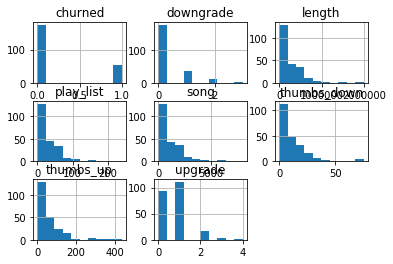

In [78]:
features_df=pd.merge(userinfo_pd, play_list_pd, how='outer', on='userId')
features_df=pd.merge(features_df, upgrade_pd, how='outer', on='userId')
features_df=pd.merge(features_df, downgrade_pd, how='outer', on='userId')
features_df=pd.merge(features_df, thumbs_up_pd, how='outer', on='userId')
features_df=pd.merge(features_df, thumbs_down_pd, how='outer', on='userId')
features_df=pd.merge(features_df, length_pd, how='outer', on='userId')
features_df=pd.merge(features_df, song_pd, how='outer', on='userId')
features_df.columns = ['userId', 'churned','play_list','upgrade', 'downgrade', 'thumbs_up', 'thumbs_down', 'length', 'song']
print(features_df.head())
features_df=features_df.fillna(0)
print(features_df.describe())
print(features_df.head())
hist = features_df.hist()

In [79]:
#play_list = data.filter(data["page"] == 'Add to Playlist').groupby('userId').count()
#userinfo=df_churned.groupby("userId").agg({"churned": "sum"})
#newdf = userinfo.join('userID','outer').join(play_list,'userID','outer')

#play_list.show(5)
#sc = SparkContext()
#sc = SparkContext.getOrCreate();
#sqlc = SQLContext(sc)

#df = sqlc.createDataFrame([play_list.count, song.count], ['colname1', 'colname2'])


In [85]:
full_data = spark.createDataFrame(features_df)
print(full_data.show())
features=full_data.drop('userId', 'churned')
print(features.show())

+------+-------+---------+-------+---------+---------+-----------+------------------+----+
|userId|churned|play_list|upgrade|downgrade|thumbs_up|thumbs_down|            length|song|
+------+-------+---------+-------+---------+---------+-----------+------------------+----+
|100010|      0|      7.0|    0.0|      0.0|     17.0|        5.0| 66940.89735000003| 275|
|200002|      0|      8.0|    1.0|      0.0|     21.0|        6.0| 94008.87593999993| 387|
|   125|      1|      0.0|    0.0|      0.0|      0.0|        0.0|2089.1131000000005|   8|
|    51|      1|     52.0|    0.0|      0.0|    100.0|       21.0| 523275.8428000004|2111|
|   124|      0|    118.0|    0.0|      0.0|    171.0|       41.0|1012312.0927899999|4079|
|     7|      0|      5.0|    0.0|      0.0|      7.0|        1.0| 38034.08710000002| 150|
|    54|      1|     72.0|    1.0|      1.0|    163.0|       29.0| 711344.9195400011|2841|
|    15|      0|     59.0|    0.0|      0.0|     81.0|       14.0|477307.60581000015|1914|

In [98]:
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in features]
print(assemblers)

TypeError: Invalid param value given for param "inputCols". Could not convert [Column<b'play_list'>] to list of strings

In [90]:
###Scaling - refercing https://www.nuomiphp.com/eplan/en/48907.html
#assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in features]
assemblers = VectorAssembler(inputCols=['play_list'], outputCol='play_list_test')

scalers = [MinMaxScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in features]
pipeline = Pipeline(stages=assemblers + scalers)
scalerModel = pipeline.fit(df)
scaledData = scalerModel.transform(df)

TypeError: Invalid param value given for param "inputCols". Could not convert [Column<b'play_list'>] to list of strings

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.